## Task 1 - Part 1

#### Step 1 − Import the necessary packages

In [17]:
# Importar bibliotecas necessárias
import numpy as np
import random
import matplotlib.pyplot as plt  # Corrigido plt00 para plt
from sklearn.linear_model import Ridge, Lasso, RANSACRegressor, LinearRegression  # Unificado as importações do sklearn.linear_model
from sklearn.model_selection import GridSearchCV, train_test_split  # Unificado imports de model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels import robust  # statsmodels não conflita com sklearn, então permanece
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


#### Step 1.5 − Picture visulazer

In [18]:
# Função para visualizar as imagens
def img_view (dataset, labels=None, num_imgs=5):
    """
    Função que visualiza um número especificado de imagens.
    
    Parâmetros:
    - dataset: Conjunto de imagens a visualizar.
    - labels: (Opcional) Rótulos das imagens, se disponíveis.
    - num_imgs: Número de imagens a visualizar.
    """
    # Verificar quantas imagens existem no dataset
    num_imgs = min(num_imgs, len(dataset))  # Garante que não tentas visualizar mais imagens do que as disponíveis

    # Criar a figura para visualização
    plt.figure(figsize=(10, 10))
    
    for i in range(num_imgs):
        plt.subplot(1, num_imgs, i+1)
        plt.imshow(dataset[i], cmap='gray')  # Usar 'gray' para imagens em escala de cinza
        plt.axis('off')
        
        if labels is not None:
            plt.title(f"Label: {labels[i]}")

    plt.show()

#### Step 2 − Load the dataset

X_train shape antes do reshape: (2783, 2304)
X_train shape depois do reshape: (2783, 48, 48)


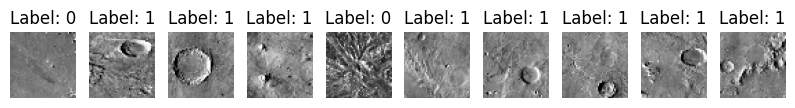

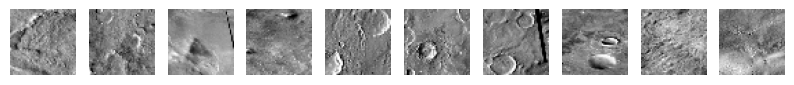

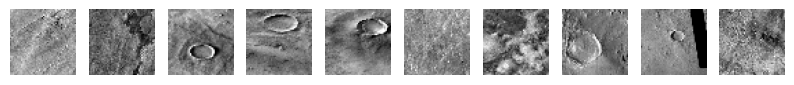

In [19]:
# Carregar os dados
X_test = np.load('Xtest1.npy')
X_train = np.load('Xtrain1.npy')
Y_train = np.load('Ytrain1.npy')
X_train_extra = np.load('Xtrain1_extra.npy')

# Verificar as dimensões dos datasets antes do reshape
print(f"X_train shape antes do reshape: {X_train.shape}")

# Reformatar as imagens para o formato correto (48, 48)
X_train = X_train.reshape(-1, 48, 48)
X_test = X_test.reshape(-1, 48, 48)
X_train_extra = X_train_extra.reshape(-1, 48, 48)

print(f"X_train shape depois do reshape: {X_train.shape}")
#############################################3
# Variável para controlar quantas imagens queres visualizar
num_imagens = 10  # Podes alterar este número para visualizar mais ou menos imagens
#######################################3


# Visualizar imagens de treino com rótulos
img_view(X_train, Y_train, num_imgs=num_imagens)

# Visualizar imagens de teste (sem rótulos)
img_view(X_test, num_imgs=num_imagens)

# Visualizar imagens do dataset extra (sem rótulos)
img_view(X_train_extra, num_imgs=num_imagens)


#### Step 2.5 - processamento

In [20]:
# 2. Preprocessamento: Reshape e Normalização
# Ajustar a forma das imagens para (48, 48, 1) para incluir o canal de cor (grayscale)
# A CNN espera 4 dimensões: (número de amostras, altura, largura, número de canais)
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Normalizar os valores dos píxeis para estar entre 0 e 1, dividindo por 255
# Isto ajuda o modelo a convergir melhor durante o treino
X_train = X_train / 255.0
X_test = X_test / 255.0

# Verificar novamente a forma após o reshape
print(f"Forma de X_train depois do reshape: {X_train.shape}")
print(f"Forma de X_test depois do reshape: {X_test.shape}")

# Dividir o conjunto de treino em treino e validação (20% dos dados para validação)
# O conjunto de validação é usado para verificar a performance do modelo durante o treino
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


Forma de X_train depois do reshape: (2783, 48, 48, 1)
Forma de X_test depois do reshape: (696, 48, 48, 1)


#### Step 3 −Definir a arquitetura da cnn 

In [21]:
# 3. Definir a CNN (Convolutional Neural Network)
# Modelo sequencial permite adicionar camadas uma após a outra
model = Sequential()

# Primeira camada convolucional:
# - 32 filtros (kernels) de 3x3
# - Função de ativação 'ReLU' (Rectified Linear Unit)
# - Input shape é 48x48 com 1 canal (grayscale)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
# MaxPooling reduz a dimensionalidade: Reduz o tamanho da imagem de 48x48 para 24x24
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segunda camada convolucional:
# - 64 filtros de 3x3
# - MaxPooling reduz ainda mais a dimensão para 12x12
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Terceira camada convolucional:
# - 128 filtros de 3x3
# - MaxPooling reduz para 6x6
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten: Converter as saídas convolucionais 3D em um vetor 1D para a camada totalmente conectada
model.add(Flatten())

# Camada densa (fully connected):
# - 128 neurónios
# - Dropout com taxa de 50% para evitar overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Desativa aleatoriamente 50% dos neurónios durante o treino

# Camada de saída:
# - 1 neurónio com ativação 'sigmoid' (porque estamos a fazer classificação binária: crater ou não crater)
model.add(Dense(1, activation='sigmoid'))


####Step 3 - Compilar o modelo

In [22]:
# 4. Compilar o modelo
# - Otimizador 'adam': uma versão otimizada do gradiente descendente
# - Função de perda 'binary_crossentropy': apropriada para problemas de classificação binária
# - Métrica 'accuracy': avalia a percentagem de previsões corretas
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#### Step 4.1 - Treinar o modelo 

In [23]:
# 5. Treinar o modelo
# - Usamos o método .fit() para treinar o modelo nos dados de treino
# - Validação é monitorizada ao usar o conjunto de validação
# - O treino ocorre por 15 épocas com um batch size de 32 (pode-se ajustar esses valores)
history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_val, Y_val))

# O objeto "history" guarda a precisão e a perda de cada época, útil para gráficos


Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6507 - loss: 0.6205 - val_accuracy: 0.8115 - val_loss: 0.4962
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8083 - loss: 0.4953 - val_accuracy: 0.8366 - val_loss: 0.3861
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8456 - loss: 0.3726 - val_accuracy: 0.8528 - val_loss: 0.3670
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8824 - loss: 0.2930 - val_accuracy: 0.8312 - val_loss: 0.3958
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8740 - loss: 0.2896 - val_accuracy: 0.8654 - val_loss: 0.3280
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8932 - loss: 0.2488 - val_accuracy: 0.8725 - val_loss: 0.3253
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9127 - loss: 0.2116 - val_accuracy: 0.8779 - val_loss: 0.3365
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9220 - loss: 0.1911 - val_accuracy: 0.8761 - v

#### Step 4 - With regularization


In [24]:
# 6. Avaliar o modelo no conjunto de teste
# - Usamos o método .evaluate() para testar o modelo nos dados não vistos
# - Ele retorna a perda e a métrica (neste caso, accuracy)
#test_loss, test_acc = model.evaluate(X_test, verbose=2)
#print(f"Test accuracy: {test_acc}")


#### Step 7 − View model


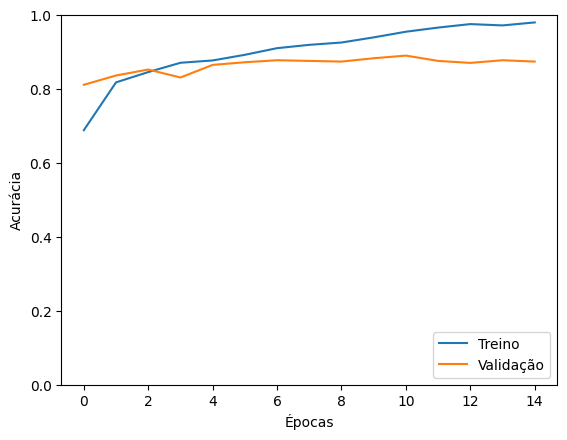

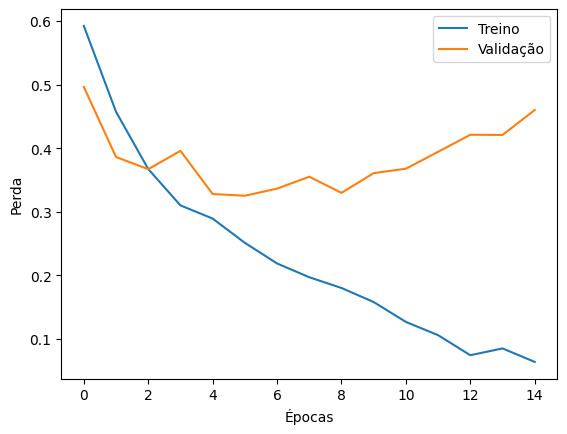

In [25]:
# 7. Gráficos da precisão de treino e validação
# - Visualizamos como a precisão evoluiu ao longo das épocas
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label = 'Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Se quiseres visualizar também a perda, podes usar:
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label = 'Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(loc='upper right')
plt.show()


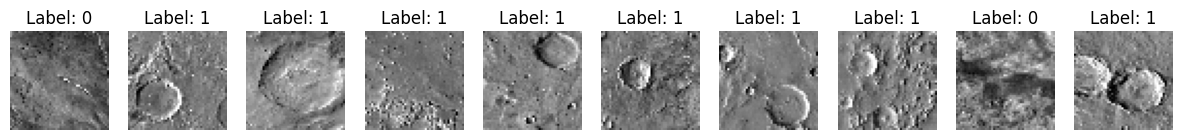

In [26]:
# Vamos mostrar as primeiras 10 imagens do conjunto de validação e seus rótulos correspondentes
# 0 - Sem cratera
# 1 - Com cratera

def visualizar_imagens_validacao(X_val, Y_val, num_imagens=10):
    plt.figure(figsize=(15, 15))
    
    for i in range(num_imagens):
        plt.subplot(1, num_imagens, i + 1)
        plt.imshow(X_val[i].reshape(48, 48), cmap='gray')  # Exibimos a imagem em escala de cinza
        plt.title(f"Label: {Y_val[i]}")
        plt.axis('off')  # Desativa os eixos
        
    plt.show()

# Chamar a função para visualizar as primeiras 10 imagens e seus rótulos
visualizar_imagens_validacao(X_val, Y_val, num_imagens=10)


In [27]:
from sklearn.metrics import f1_score

# Fazer previsões no conjunto de validação (X_val)
# O modelo gera probabilidades, então usamos um limiar de 0.5 para classificar
Y_pred_val = (model.predict(X_val) > 0.5).astype("int32")

# Calcular o F1 Score
f1 = f1_score(Y_val, Y_pred_val)

print(f"F1 Score no conjunto de validação: {f1:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
F1 Score no conjunto de validação: 0.9030
